表1
|DAN|DAN预激活的KC|
|:--:| :--: |
|0	|0，1|
|1	|2，3|
|2	|4，5|

### 已经实现
1. 随机让KC，MBON激活，这一步是训练KC到MBON的权重
   + 同时兴奋，有奖励，KM突触连接权重增强
   + 不同时兴奋，有奖励，KM突触连接权重减弱
   + 无奖励，KM突触连接权重不变
   + τdw/dt=(α * V_前  − β * w)* V_后* R, α>=β
2. KC输出兴奋程度的输入来源有两方面   1.sensor输入 2.DAN预激活
3. MBON激活程度 = KC * WeightKM
4. MBON达到激活阈值，对应DAN也激活
5. DAN激活，会导致KC预激活（额外）,如表1

### 问题
+ DAN到KC的权重如何更新
+ KC到DAN的权重如何更新
  + 如何根据KC增量，激活DAN

In [ ]:
import numpy as np


def sigmoid(x):
    return 1 / (1 + np.exp(-(np.array(x)-2)))


def rk4(h, y, inputs, f):
    '''
    用于数值积分的rk4函数。
    args:
        h - 步长
        y - 当前状态量
        inputs - 外界对系统的输入
        f - 常微分或偏微分方程
    return:
        y_new - 新的状态量,即经过h时间之后的状态量
    '''
    k1 = f(y, inputs)
    k2 = f(y + h / 2 * k1, inputs)
    k3 = f(y + h / 2 * k2, inputs)
    k4 = f(y + h * k3, inputs)

    y_new = y + h / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
    return y_new


class KMDmodel:
    def __init__(self, numKC=6,numMBON=3,numDAN=3) -> None:
        # sensor输入
        self.inputsensor = np.zeros(numKC,dtype=float)
        # DAN预激活KC
        self.DANpotentialKC = {'0':[0,1],'1':[2,3],'2':[4,5]}
        # MBON的激活阈值
        self.thresholdMBON = 0.5
        # 当前兴奋程度
        self.KC = np.zeros(numKC,dtype=float)
        self.MBON = np.zeros(numMBON,dtype=float)
        self.DAN = np.zeros(numDAN,dtype=float)
    
    def outputKC(self, inputsensor, inputDAN):
        """
        KC输出兴奋程度来源有两方面
        1.sensor输入 2.DAN预激活
        """
        pokc = []
        for i, value in enumerate(inputDAN):
            if value == 1:
                pokc.append(self.DANpotentialKC[str(i)])
        for i in pokc:
            for j in i:
                self.KC[j] += 1
        self.KC = sigmoid(inputsensor + self.KC)        
        return self.KC
    
    def outputMBON(self, weightKM):
        """
        MBON输出兴奋程度 = KC * Weight_KM
        """
        self.MBON = sigmoid(np.dot(self.KC,weightKM))
        return self.MBON

    def outputDAN(self):
        """
        DAN输出兴奋程度，先简化为对应的MBON到达激活阈值，DAN就激活
        """
        for index, value in enumerate(self.MBON):
            if value >= self.thresholdMBON:
                self.DAN[index] = 1
        return self.DAN
    

class Synapse:
    def __init__(self, numPreNeuron, numPostNeuron) -> None:
        self.numPreNeuron = numPreNeuron
        self.numPostNeuron = numPostNeuron
        self.PreNeuron = np.array([np.zeros(numPreNeuron, dtype=float)])
        self.PostNeruon = np.array([np.zeros(numPostNeuron, dtype=float)])
        self.weight = np.zeros([numPreNeuron,numPostNeuron])
        self.reward = np.zeros(1)
        # 超参数
        self.alpha = 1
        self.tau = 1
        self.beta = 1
        self.dt = 1
    
    def derivative(self, state, inputs=0):
        w = state
        Dw = (np.matmul(self.alpha * (np.tile(self.PreNeuron.T, self.numPostNeuron) - w), self.beta * np.tile(self.PostNeruon.T, self.numPostNeuron)) * self.reward) / self.tau
        return Dw
    
    def step(self, state, dt=1, inputs=0):
        statenew = rk4(dt, state, inputs, self.derivative)
        return statenew
    
    
# if __name__  == "__main__":
kmd = KMDmodel()
kmd.MBON = [0,1,0.5]
inputsensor = [0,1,1,1,1,1]
kmd.outputKC(inputsensor,kmd.outputDAN())

KCtoMBON = Synapse(6,3)
w = KCtoMBON.step(KCtoMBON.weight)
kmd.outputMBON(w)


[[0.11920292]
 [0.59583591]
 [0.30875893]]
[[0.93520938 0.896335   0.92225125 0.88337687 0.88337687 0.88337687]
 [0.87041875 0.79267    0.8445025  0.76675375 0.76675375 0.76675375]
 [0.80562813 0.689005   0.76675375 0.65013063 0.65013063 0.65013063]]
[[0.91165394 0.91337087 0.91222625 0.91394318 0.91394318 0.91394318]
 [0.82330787 0.82674174 0.8244525  0.82788637 0.82788637 0.82788637]
 [0.73496181 0.74011261 0.73667874 0.74182955 0.74182955 0.74182955]]
[[1.00450455 1.00720728 1.00540546 1.00810819 1.00810819 1.00810819]
 [1.0090091  1.01441455 1.01081091 1.01621637 1.01621637 1.01621637]
 [1.01351364 1.02162183 1.01621637 1.02432456 1.02432456 1.02432456]]


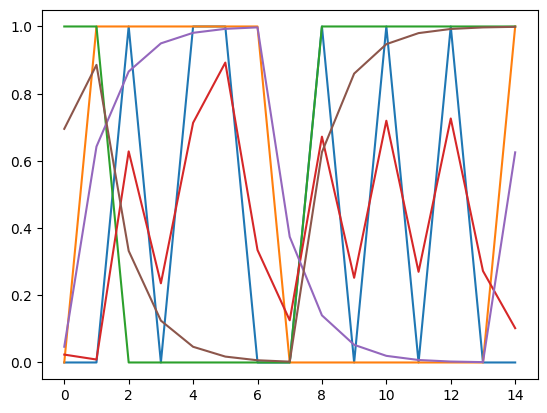

In [47]:
import random
from matplotlib import pyplot as plt
import numpy as np


def rk4(h, y, inputs, f):
    '''
    用于数值积分的rk4函数。
    args:
        h - 步长
        y - 当前状态量
        inputs - 外界对系统的输入
        f - 常微分或偏微分方程
    return:
        y_new - 新的状态量,即经过h时间之后的状态量
    '''
    k1 = f(y, inputs)
    k2 = f(y + h / 2 * k1, inputs)
    k3 = f(y + h / 2 * k2, inputs)
    k4 = f(y + h * k3, inputs)

    y_new = y + h / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
    return y_new


def sigmoid(x):
    return 1 / (1 + np.exp(-(np.array(x)-2)))


class KMDmodel:
    def __init__(self, numKC=6,numMBON=3,numDAN=3) -> None:
        # sensor输入
        self.inputsensor = np.array([np.zeros(numKC,dtype=float)]).T  # shape:[6,1]
        # DAN预激活KC
        self.DANpotentialKC = {'0':[0,1],'1':[2,3],'2':[4,5]}
        # MBON的激活阈值
        self.thresholdMBON = 0.5
        # 当前兴奋程度
        self.KC = np.array([np.zeros(numKC,dtype=float)]).T  # shape:[6,1]
        self.MBON = np.array([np.zeros(numMBON,dtype=float)]).T  # shape:[3,1]
        self.DAN = np.array([np.zeros(numDAN,dtype=float)]).T  # shape:[3,1]
    
    def outputKC(self, inputsensor, inputDAN):
        """
        KC输出兴奋程度来源有两方面
        1.sensor输入 2.DAN预激活
        """
        pokc = []
        for i, value in enumerate(inputDAN):
            if value == 1:
                pokc.append(self.DANpotentialKC[str(i)])
        for i in pokc:
            for j in i:
                self.KC[j][0] += 1
        self.KC = sigmoid(inputsensor + self.KC)        
        return self.KC
    
    def outputMBON(self, weightKM):
        """
        MBON输出兴奋程度 =  Weight_KM * KC 即3*1=3*6 * 6*1
        """
        self.MBON = sigmoid(np.matmul(weightKM, self.KC))
        return self.MBON

    def outputDAN(self):
        """
        DAN输出兴奋程度，先简化为对应的MBON到达激活阈值，DAN就激活
        """
        for index, value in enumerate(self.MBON):
            if value >= self.thresholdMBON:
                self.DAN[index] = 1
            else:
                self.DAN[index] = 0
        return self.DAN


kmd = KMDmodel()
kmd.MBON = np.array([[0,1,0.5]]).T  # (3, 1)
inputsensor = np.array([[0,1,1,1,1,1]]).T  # (6, 1)
kmd.outputKC(inputsensor,kmd.outputDAN())
# TODO:w为km的权重
w = np.tile(np.array([[0,1,0.5]]).T , 6)
print(kmd.outputMBON(w))
  
    
class Synapse:
    def __init__(self, numPreNeuron, numPostNeuron, reward=1, alpha=1, tau=1, tau_lowpass=1, beta=1, dt=0.1, dt_lowpass=1) -> None:
        self.numPreNeuron = numPreNeuron
        self.numPostNeuron = numPostNeuron
        self.PreNeuron = np.array([np.zeros(numPreNeuron, dtype=float)]).T  # shape:(numPreNeuron, 1)
        self.PreNeuronHistory = np.array([np.zeros(numPreNeuron, dtype=float)]).T
        self.PostNeuron = np.array([np.zeros(numPostNeuron, dtype=float)]).T  # shape:(numPostNeuron, 1)
        self.PostNeuronHistory = np.array([np.zeros(numPostNeuron, dtype=float)]).T
        self.weight = np.zeros([numPostNeuron, numPreNeuron])  # shape:(numPostNeuron, numPreNeuron)
        self.reward = np.array(reward)  # shape: (1)
        # 超参数
        self.alpha = alpha
        self.tau = tau
        self.tau_lowpass = tau_lowpass
        self.beta = beta
        self.dt = dt
        self.dt_lowpass = dt_lowpass
    
        
    def derivative(self, state, inputs=0):
        """
        1. 同时兴奋，有奖励，突触连接权重增强
        2. 前不兴奋，后兴奋，(不同时)，有奖励，突触连接权重减弱
        3. 无奖励，突触连接权重不变
        4. τdw/dt=(α * V_前  − w) * (β * V_后) * R, α>β?
        """
        w = state
        # Dw = (np.matmul(self.alpha * (np.tile(self.PreNeuron, self.numPostNeuron) - w), self.beta * np.tile(self.PostNeruon.T, self.numPostNeuron)) * self.reward) / self.tau
        Dw = (np.matmul(self.beta * np.tile(self.PostNeuron, self.numPostNeuron),  (self.alpha * self.PreNeuron.T - w))* self.reward) / self.tau
        return Dw
    
    def step(self, dt, inputs=0):
        if dt is None:
            dt = self.dt
        state = self.weight
        statenew = rk4(dt, state, inputs, self.derivative)
        return statenew

    
class SynapseKM(Synapse):
    def __init__(self, numPreNeuron, numPostNeuron, reward=1, alpha=1, tau=1, tau_lowpass=1, beta=1, dt=0.1, dt_lowpass=1) -> None:
        super().__init__(numPreNeuron, numPostNeuron, reward, alpha, tau, tau_lowpass, beta, dt, dt_lowpass)    

    def derivative(self, state, inputs=0):
        return super().derivative(state, inputs)
    
    def step(self, dt, inputs=0):
        return super().step(dt, inputs)


random.seed(1)
skm = SynapseKM(6,3)
skm.weight = np.ones([3, 6])
skm.PreNeuron = np.array([[0.5, 0.2, .4, .1, .1, .1]]).T
skm.PostNeuron = np.array([[0.1, 0.2, 0.3]]).T
print(skm.step(dt=0.5))

    
class SynapseKD(Synapse):
    def __init__(self, numPreNeuron, numPostNeuron, reward=1, alpha=1, tau=1, tau_lowpass=1, beta=1, dt=0.1, dt_lowpass=1) -> None:
        super().__init__(numPreNeuron, numPostNeuron, reward, alpha, tau, tau_lowpass, beta, dt, dt_lowpass)
    
    def derivativePre(self, state, inputs=0):
        history = state
        Dhistory = self.tau_lowpass * (self.PreNeuron - history)  
        return Dhistory
        
    def stepPre(self, dt_lowpass, inputs=0):
        state = self.PreNeuronHistory
        statenew = rk4(dt_lowpass, state, inputs, self.derivativePre)      
        self.PreNeuronHistory = statenew
        return statenew   
     
    def derivativePost(self, state, inputs=0):
        history = state
        Dhistory = self.tau_lowpass * (self.PostNeruon - history)  
        return Dhistory
        
    def stepPost(self, dt_lowpass, inputs=0):
        state = self.PostNeuronHistory
        statenew = rk4(dt_lowpass, state, inputs, self.derivativePost)      
        self.PostNeuronHistory = statenew
        return statenew
    
    def derivative(self, state, inputs=0):
        w = state
        self.PreNeuron = self.PreNeuron - self.stepPre(dt_lowpass=self.dt_lowpass)  # 改2瞬时 为 3瞬时-低通滤波
        self.PostNeruon = self.stepPost(dt_lowpass=self.dt_lowpass)  # 改2瞬时 为 1低通滤波
        # Dw = (np.matmul(self.alpha * (np.tile(self.PreNeuron, self.numPostNeuron) - w), self.beta * np.tile(self.PostNeruon.T, self.numPostNeuron)) * self.reward) / self.tau
        Dw = (np.matmul(self.beta * np.tile(self.PostNeruon, self.numPostNeuron),  (self.alpha * self.PreNeuron.T - w))* self.reward) / self.tau
        return Dw
    
    def step(self, dt, inputs=0):
        if dt is None:
            dt = self.dt
        state = self.weight
        statenew = rk4(dt, state, inputs, self.derivative)
        return statenew


random.seed(1)
skd = SynapseKD(6,3)
skd.weight = np.ones([3, 6])
skd.PreNeuron = np.array([[0.5, 0.2, .4, .1, .1, .1]]).T
skd.PostNeruon = np.array([[0.1, 0.2, 0.3]]).T
print(skd.step(dt=0.5))


class SynapseDK(Synapse):
    def __init__(self, numPreNeuron, numPostNeuron, reward=1, alpha=1, tau=1, tau_lowpass=1, beta=1, dt=0.1, dt_lowpass=1) -> None:
        super().__init__(numPreNeuron, numPostNeuron, reward, alpha, tau, tau_lowpass, beta, dt, dt_lowpass)
        
    def derivativePost(self, state, inputs=0):
        history = state
        Dhistory = self.tau_lowpass * (self.PostNeruon - history)  
        return Dhistory
        
    def stepPost(self, dt_lowpass, inputs=0):
        state = self.PostNeuronHistory
        statenew = rk4(dt_lowpass, state, inputs, self.derivativePost)      
        self.PostNeuronHistory = statenew
        return statenew
    
    def derivative(self, state, inputs=0):
        w = state
        self.PostNeruon = self.PostNeruon - self.stepPost(dt_lowpass=self.dt_lowpass)  # 改2瞬时 为 3瞬时-低通滤波
        # Dw = (np.matmul(self.alpha * (np.tile(self.PreNeuron, self.numPostNeuron) - w), self.beta * np.tile(self.PostNeruon.T, self.numPostNeuron)) * self.reward) / self.tau
        Dw = (np.matmul(self.beta * np.tile(self.PostNeruon, self.numPostNeuron),  (self.alpha * self.PreNeuron.T - w))* self.reward) / self.tau
        return Dw
    
    def step(self, dt, inputs=0):
        return super().step(dt, inputs)

    
random.seed(1)
sdk = SynapseDK(6,3)
sdk.weight = np.ones([3, 6])
sdk.PreNeuron = np.array([[0.5, 0.2, .4, .1, .1, .1]]).T
sdk.PostNeruon = np.array([[0.1, 0.2, 0.3]]).T
print(sdk.step(dt=0.5))

historylist = []
inputlist = []
t = range(15)
for i in t:
    skd.PostNeruon = np.array([[random.choice([0,1]) for _ in range(3)]]).T  # shape:(3, 1)
    history = skd.stepPost(dt_lowpass=1)  # shape:(3, 1)
    inputlist.append(skd.PostNeruon.T[0])  # shape:(1, 3)[0]=(3) 
    historylist.append(history.T[0])  # shape:(1, 3)[0]=(3)

plt.figure()
plt.plot(t,inputlist)
plt.plot(t,historylist)
plt.show()